In [3]:
import zipfile
with zipfile.ZipFile('brain_tumor_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_dataset')

In [4]:
import os
from PIL import Image

base_dir = '/brain_tumor_dataset'

# Example: Load and visualize one image from the 'yes' folder
yes_dir = 'brain_tumor_dataset/brain_tumor_dataset/yes'
no_dir = 'brain_tumor_dataset/brain_tumor_dataset/no'

In [5]:
import numpy as np

def load_images_from_folder(folder, image_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = Image.open(file_path).resize(image_size).convert('RGB')  # Resize and convert to RGB
        images.append(np.array(img) / 255.0)  # Normalize pixel values to [0, 1]
    return np.array(images)

# Load images from both folders
yes_images = load_images_from_folder(yes_dir)
no_images = load_images_from_folder(no_dir)

print(f"Loaded {len(yes_images)} 'yes' images and {len(no_images)} 'no' images.")

X = np.concatenate((yes_images, no_images), axis=0)
y = np.array([1] * len(yes_images) + [0] * len(no_images))  # Labels: 1 for 'yes', 0 for 'no'

print(f"Combined dataset: {X.shape[0]} images, Labels: {y.shape[0]}")

Loaded 155 'yes' images and 98 'no' images.
Combined dataset: 253 images, Labels: 253


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 202 images
Testing set: 51 images


In [7]:
import tensorflow as tf

# Normalize pixel values to [0, 1] (Feature Scaling)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Define Data Augmentation for Training Data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,         # Rotate images up to 20 degrees
    width_shift_range=0.2,     # Shift images horizontally
    height_shift_range=0.2,    # Shift images vertically
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels after transformations
)

# Apply augmentation to the training data
datagen.fit(X_train)  # Precompute augmentation transformations for X_train

# Testing generator only normalizes
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Wrap training and testing data for generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

print("done")

2024-11-20 11:12:11.620183: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 11:12:12.257971: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


done


In [10]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Load ResNet50V2
base_model_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model_resnet.trainable = False  # Freeze base model

# Add custom classification head
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=x)

# Compile the model
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
from tensorflow.keras.applications import VGG19
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load VGG19
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model_vgg.trainable = False  # Freeze base model

# Add custom classification head
x = base_model_vgg.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=x)

# Compile the model
model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



80134624/80134624 [==============================] - 0s 0us/step


In [11]:
# Train ResNet50V2
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # Adjust based on your dataset
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)


Epoch 1/10
7/7 [==============================] - 11s 1s/step - loss: 0.6826 - accuracy: 0.5644 - val_loss: 0.6924 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.6710 - accuracy: 0.5743 - val_loss: 0.7086 - val_accuracy: 0.5294
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.6696 - accuracy: 0.6188 - val_loss: 0.7076 - val_accuracy: 0.5294
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.6761 - accuracy: 0.6337 - val_loss: 0.7034 - val_accuracy: 0.5294
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.6783 - accuracy: 0.6139 - val_loss: 0.7006 - val_accuracy: 0.5294
Epoch 6/10
7/7 [==============================] - 8s 1s/step - loss: 0.6511 - accuracy: 0.6188 - val_loss: 0.6933 - val_accuracy: 0.5294
Epoch 7/10
7/7 [==============================] - 8s 1s/step - loss: 0.6514 - accuracy: 0.6386 - val_loss: 0.6953 - val_accuracy: 0.5294
Epoch 8/10
7/7 [========================

In [17]:
# Train VGG19
history_vgg = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # Adjust based on your dataset
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)


Epoch 1/10
7/7 [==============================] - 27s 4s/step - loss: 0.7530 - accuracy: 0.5693 - val_loss: 0.7687 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 26s 4s/step - loss: 0.7419 - accuracy: 0.5396 - val_loss: 0.7014 - val_accuracy: 0.4706
Epoch 3/10
7/7 [==============================] - 26s 4s/step - loss: 0.7789 - accuracy: 0.5347 - val_loss: 0.8435 - val_accuracy: 0.5294
Epoch 4/10
7/7 [==============================] - 26s 4s/step - loss: 0.8181 - accuracy: 0.4752 - val_loss: 0.7670 - val_accuracy: 0.5294
Epoch 5/10
7/7 [==============================] - 26s 4s/step - loss: 0.7305 - accuracy: 0.5594 - val_loss: 0.7397 - val_accuracy: 0.5294
Epoch 6/10
7/7 [==============================] - 26s 4s/step - loss: 0.7220 - accuracy: 0.5891 - val_loss: 0.7233 - val_accuracy: 0.5294
Epoch 7/10
7/7 [==============================] - 26s 4s/step - loss: 0.7057 - accuracy: 0.5545 - val_loss: 0.7594 - val_accuracy: 0.5294
Epoch 8/10
7/7 [==================

In [13]:
# Evaluate ResNet50V2
resnet_eval = model_resnet.evaluate(test_generator)
print(f"ResNet50V2 - Loss: {resnet_eval[0]}, Accuracy: {resnet_eval[1]}")


2/2 [==============================] - 1s 522ms/step - loss: 0.6853 - accuracy: 0.5294
ResNet50V2 - Loss: 0.6852831840515137, Accuracy: 0.529411792755127


In [18]:
# Evaluate VGG19
vgg_eval = model_vgg.evaluate(test_generator)
print(f"VGG19 - Loss: {vgg_eval[0]}, Accuracy: {vgg_eval[1]}")


2/2 [==============================] - 5s 2s/step - loss: 0.7139 - accuracy: 0.5294
VGG19 - Loss: 0.7139337062835693, Accuracy: 0.529411792755127


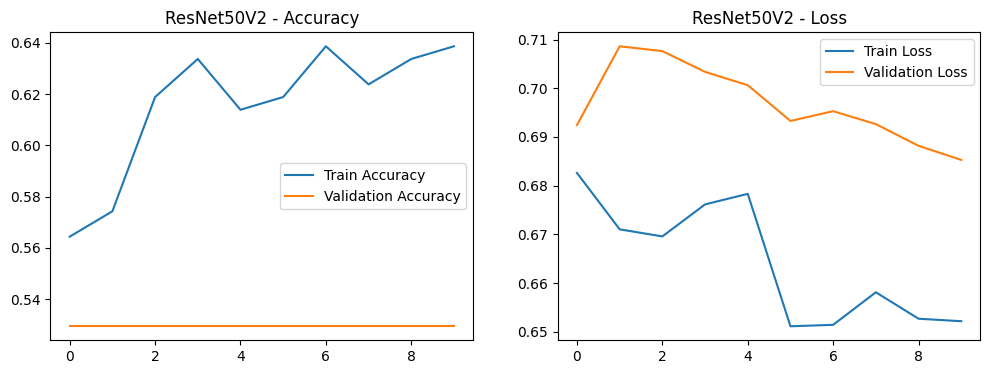

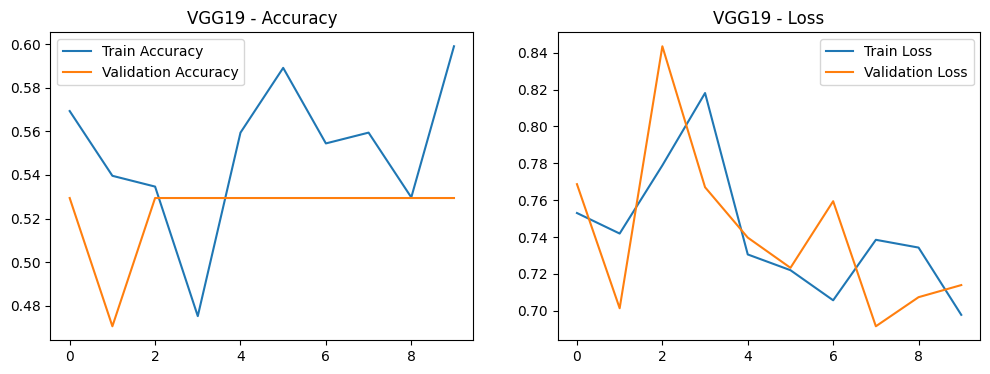

In [19]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_resnet, "ResNet50V2")
plot_history(history_vgg, "VGG19")


In [20]:
model_resnet.save('resnet50v2_brain_tumor.h5')
model_vgg.save('vgg19_brain_tumor.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
